# Exploration 4. 작사가 인공지능 만들기!

## ★프로젝트의 목표★
- 가사 텍스트 제너레이션 모델을 통해 생성한 결과가 그럴듯한 문장으로 도출되도록 할 수 있는지?
- 특수문자 제거, 토크나이저 생성, 패딩 처리 등 데이터의 전처리 및 데이터셋 구성 과정을 수행할 수 있는지?
- 텍스트 생성 모델의 validation loss 값이 2.2 이하로 내려오는지? 그렇지 못했다면 원인은 무엇인지?

### Step 1. 필요한 데이터 준비하기

- Cloud Shell에 Symbolic Link로 ~/aiffel/lyricist/data를 생성하면 data의 하위항목인 lyrics 폴더에 데이터가 들어있는 것을 확인할 수 있다.

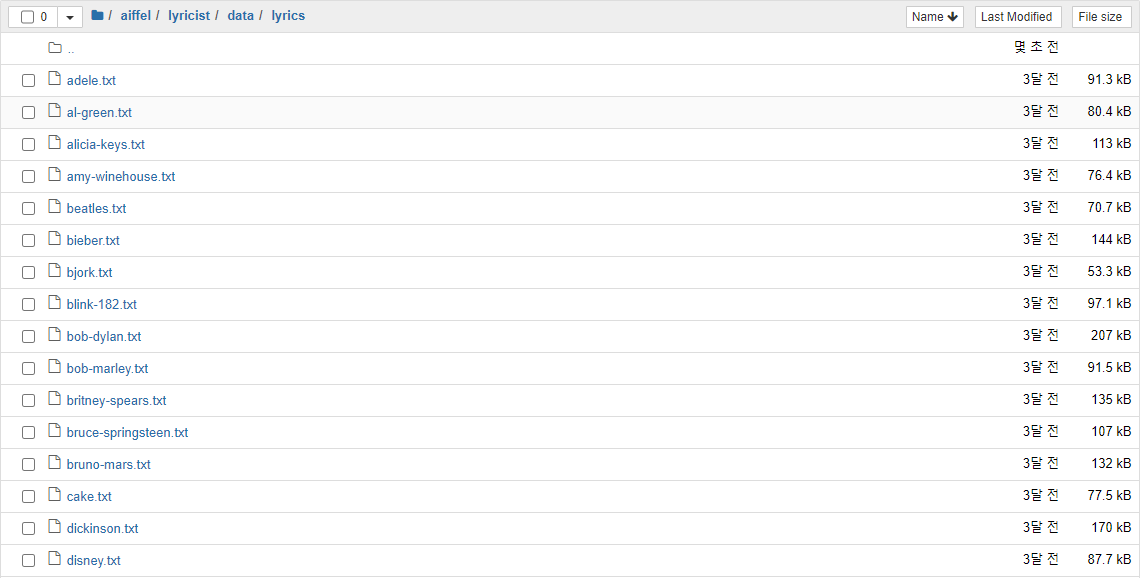

### Step 2. 데이터 읽어오기

- 아래와 같이 **glob를 활용하여** 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장한다.

In [1]:
import glob
import os
import numpy as np
import re
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기 :", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기 : 187088
Examples:
 ['At first I was afraid', 'I was petrified', 'I kept thinking I could never live without you']


### Step 3. 데이터 정제하기

- **preprocess_sentence()** 메서드를 활용하여 데이터를 정제한다.
- 너무 긴 문장은 노래 가사를 작사하는 데는 적합하지 않다. 또한 다른 데이터들이 과도한 Padding을 갖게 하므로 제거를 요한다.
- 가급적 토큰화하였을 때, 토큰의 개수가 15개 이하인 문장을 사용하도록 권장한다.

**▶ raw_corpus 내의 문장 데이터에서 조건을 만족하는 문장 출력하기**

In [15]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 6: break   # 문장 9개만 확인해 볼 겁니다.
        
    print(sentence)

At first I was afraid
I was petrified
I kept thinking I could never live without you
By my side But then I spent so many nights
Just thinking how you've done me wrong
I grew strong
I learned how to get along And so you're back


**▶ 출력된 문장 데이터 정제하기**

In [16]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:6]

['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>',
 '<start> i grew strong <end>']

**▶ 토큰화하기**

In [17]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   71  241 ...    0    0    0]
 [   2    5   57 ...    0    0    0]
 [   2    5 1094 ...    0    0    0]
 ...
 [   2   48   16 ...    0    0    0]
 [   2    5   22 ...    0    0    0]
 [   2    6  180 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f3365e35b50>


**생성된 Tensor 데이터를 슬라이스를 사용하여 출력하기**
- 텐서 데이터는 모두 정수로 구성되어 있다.

In [18]:
print(tensor[:3, :8])    ## 세 번째 행, 여덟 번째 열까지만 출력

[[   2   71  241    5   57  664    3    0]
 [   2    5   57 6481    3    0    0    0]
 [   2    5 1094  534    5  104   79  205]]


**단어사전 구축하기**
- 텐서 데이터를 이루는 정수는 tokenizer에 구축된 단어 사전의 index이다.
- 출력 결과로 미루어보았을 때, print(tensor[:3, :8])에 대한 각 리스트 요소의 시작 값이 2인데, 이는 아래 코드에서의 < start > 를 나타낸다.
- 텐서 출력에서 행 뒤쪽에 갈수록 0이 많이 확인되는데, 이는 정해진 입력 sequence length보다 문장이 짧았기 때문이다. 이러한 경우 패딩(padding) 기술을 이용해 빈칸을 행과 열에 맞게 0으로 채워 넣는다.
- 단어사전에는 존재하지 않으나 0이 가리키는 것은 < pad > 임을 짐작해볼 수 있을 것이다.

In [19]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 12: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me


**corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장 확인하기**

In [20]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  71 241   5  57 664   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

**tf.data.Dataset.from_tensor_slices() 활용하여 데이터셋 객체 생성하기**

In [21]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 346), (256, 346)), types: (tf.int32, tf.int32)>

### Step 4. 평가 데이터셋 분리 (scikit-learn 활용)

- 훈련 데이터와 평가 데이터를 분리하기 위해 scikit-learn의 train_test_split() 함수를 사용한다.

In [54]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,
    test_size = 0.3,
    random_state = 15)

In [55]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (123024, 346)
Target Train: (123024, 346)


### Step 5. 인공지능 만들기

In [32]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [33]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 346, 7001), dtype=float32, numpy=
array([[[ 6.68965877e-05,  1.31541557e-04,  1.60154363e-04, ...,
         -2.46125273e-04, -3.88140070e-05,  6.18260165e-05],
        [-8.91203090e-05, -3.15129990e-04,  2.30647245e-04, ...,
         -1.06845306e-04,  3.30911891e-04,  1.34786547e-04],
        [ 4.07600646e-06, -5.07322897e-04, -8.83261600e-05, ...,
         -3.28663955e-05,  5.41322457e-04,  1.23394930e-04],
        ...,
        [ 2.05361354e-03,  9.39891301e-03,  2.47954903e-03, ...,
          2.63536489e-03,  1.05764880e-03,  9.08598246e-04],
        [ 2.05361308e-03,  9.39891394e-03,  2.47954973e-03, ...,
          2.63536465e-03,  1.05764845e-03,  9.08598420e-04],
        [ 2.05361308e-03,  9.39891394e-03,  2.47954996e-03, ...,
          2.63536442e-03,  1.05764915e-03,  9.08598769e-04]],

       [[ 6.68965877e-05,  1.31541557e-04,  1.60154363e-04, ...,
         -2.46125273e-04, -3.88140070e-05,  6.18260165e-05],
        [ 1.94578635e-04,  3.13272991e-04,  2

In [34]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [35]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[88576,7001] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node text_generator/dense/Tensordot/MatMul (defined at <ipython-input-32-f3995e0333db>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[gradient_tape/text_generator/embedding/embedding_lookup/Reshape/_20]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[88576,7001] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node text_generator/dense/Tensordot/MatMul (defined at <ipython-input-32-f3995e0333db>:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3958]

Function call stack:
train_function -> train_function


In [58]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [59]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he duck clear zip zip district district pearl jumpjump serve district cans cans cans '